# __SpringBoard Capstone Project 1: Machine Learning__
## __(Cervical Cancer Dataset)__

__Written by: Sofy Weisenberg__<br>
__Date: 02/18/20__


__Step 1: Importing the Dataset and Data Preparation__<br>
Import the original dataset and perform data wrangling steps to prepare data for analysis (for details on these steps, see: https://github.com/s-weisenberg/Springboard/blob/master/Capstone_Project_1/Capstone1_Data_Wrangling.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

df = pd.read_csv('kag_risk_factors_cervical_cancer.csv')
df = df.replace('?', np.nan)
for column, values in df.iteritems():
        df[column] = pd.to_numeric(df[column], errors='coerce')
df = df.drop(['STDs: Time since first diagnosis','STDs: Time since last diagnosis'], axis=1)
df = df.fillna(df.median())
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


__Step 2: Splitting the Data__<br>
The dataframe needs to be split into the feature and target data and some data must be set aside for model validation.

In [2]:
from sklearn.model_selection import train_test_split

# split the data into features and target 
X = df.drop(['Biopsy'],axis=1)
y = df['Biopsy']

random_state = np.random.RandomState(0)

# perform stratified test-train split to hold off 25% of data for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=random_state)

__Step 3: Fitting a ML model__<br>
As a start, a few traditional ML models will be fit to the data. Later, a deep learning model will be implemented for comparison. To start off, a logistic regression model will be fit to the data.

Hyperparameter tuning is be accomplished via grid search coupled with 5-fold cross-validation. Several hyperparameters are considered, and the parameters' performance is evaluated using the F1 score, which takes into account both precision and recall. Though the F1 score assumes equal weight for precision and recall (when in reality recall/sensitivity is of higher priority), since no other weighting scheme is known a priori, it is an acceptable default. As a note: other classifier scoring metrics (e.g. log loss, Brier score loss, ROC AUC) were also tried and gave very similar hyperparameter optimizations. 

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

logistic = LogisticRegression(random_state=random_state)

# define hyperparameter options
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
#class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
class_weight = [{1:0.7, 0:0.3}, {1:0.8, 0:0.2}, {1:0.9, 0:0.1}, {1:0.95, 0:0.05}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=logistic,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = 5)

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    4.0s finished
C:\Users\Niv\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score (F1): 0.7240
Best Params:  {'C': 1, 'class_weight': {1: 0.9, 0: 0.1}, 'penalty': 'l1', 'solver': 'liblinear'}



Note: Trying 'recall' as the scoring method, which could be justified as we wish to reduce false negatives, gives a perplexing optimization. It reaches a recall score of 1 (perhaps for some trivial combination of hyperparameters?). The resulting combination does not generalize well at all to the test set, so perhaps a case of overfitting?.

__Step 4: Selecting Final Model Evaluation Criteria__<br>

From https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/:

Reviewing both precision and recall is useful in classification problems where there is an imbalance in the observations between the two classes (see https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432). Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1). This is indeed the case for this dataset.

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives. Key to the calculation of precision and recall is that the calculations do not make use of the true negatives. It is only concerned with the correct prediction of the minority class, class 1.

Therefore, the precision-recall performance as well as the log loss, another common classifier performance metric, will be examined for the final logistic regression model. These metrics can later be used to compare various ML models.

In [4]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss

model = grid_result.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss = log_loss(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss))

Average precision-recall score: 0.61
Log loss: 1.29


In [5]:
from sklearn.metrics import classification_report

target_names = ['Biopsy = 0', 'Biopsy = 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Biopsy = 0       0.99      0.97      0.98       201
  Biopsy = 1       0.65      0.93      0.76        14

    accuracy                           0.96       215
   macro avg       0.82      0.95      0.87       215
weighted avg       0.97      0.96      0.97       215



Text(0, 0.5, 'Precision')

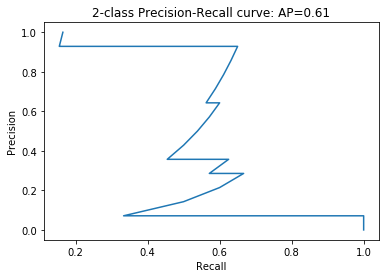

In [6]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(precision, recall)
plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')


__Step 5: Evaluating Additional ML Models__<br>

Additional traditional ML classifier models may be fit to the data:
- Support Vector Classifier (SVC) - an application of support vector machine (SVM)
- Random Forest Classifier - decision tree ensemble method using bootstrapping
- k Nearest Neighbors Classifier (k-NN)

A deep learning (neural network) model using Keras will also be implemented and compared.

__Support Vector Classifier (SVC)__<br>

In [7]:
from sklearn.svm import SVC

svc = SVC(probability = True, random_state=random_state)

# define hyperparameter options
param_grid = {'C': [0.1, 1, 100, 1000, 10000],
              'gamma': [1, 0.1, 0.01, 0.0001, 0.00001],
              'kernel': ['rbf']} 

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=svc,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = 5)

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    1.0s finished
C:\Users\Niv\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score (F1): 0.6762
Best Params:  {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [8]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss

model = grid_result.best_estimator_
y_pred = model.predict(X_test)
#y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss = log_loss(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss))

Average precision-recall score: 0.47
Log loss: 1.61


In [9]:
from sklearn.metrics import classification_report

target_names = ['Biopsy = 0', 'Biopsy = 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Biopsy = 0       0.98      0.97      0.97       201
  Biopsy = 1       0.62      0.71      0.67        14

    accuracy                           0.95       215
   macro avg       0.80      0.84      0.82       215
weighted avg       0.96      0.95      0.95       215



Text(0, 0.5, 'Precision')

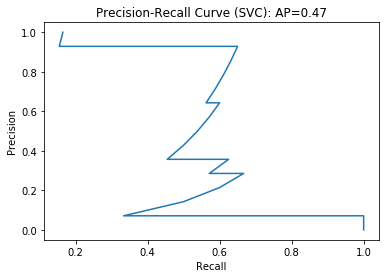

In [10]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(precision, recall)
plt.title('Precision-Recall Curve (SVC): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')


__Random Forest Classifier (SVC)__<br>

In [25]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=random_state)

# define hyperparameter options
param_grid = {'n_estimators': [200, 500, 1000],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4, 6, 8, 10],
              'criterion' :['gini', 'entropy']
}

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=rfc,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = 5)

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.0s finished
C:\Users\Niv\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score (F1): 0.5385
Best Params:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}


In [26]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss

model = grid_result.best_estimator_
y_pred = model.predict(X_test)
#y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
log_loss = log_loss(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Log loss: {0:0.2f}'.format(log_loss))

Average precision-recall score: 0.32
Log loss: 1.77


In [27]:
from sklearn.metrics import classification_report

target_names = ['Biopsy = 0', 'Biopsy = 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Biopsy = 0       0.96      0.99      0.97       201
  Biopsy = 1       0.67      0.43      0.52        14

    accuracy                           0.95       215
   macro avg       0.81      0.71      0.75       215
weighted avg       0.94      0.95      0.94       215



Text(0, 0.5, 'Precision')

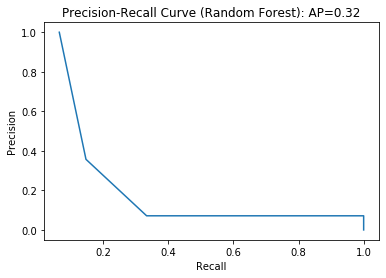

In [28]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(precision, recall)
plt.title('Precision-Recall Curve (Random Forest): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')


__K Nearest Neighbors Classifier (k-NN)__<br>

In [33]:
from sklearn.neighbors import KNeighborsClassifier

k_nn = KNeighborsClassifier()

# define hyperparameter options
k_range = list(range(1, 40))
param_grid = dict(n_neighbors=k_range)

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=k_nn,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = 4)

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 4 folds for each of 39 candidates, totalling 156 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    2.5s finished
C:\Users\Niv\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Score (F1): 0.0719
Best Params:  {'n_neighbors': 1}


In [34]:
#model = grid_result.best_estimator_
model = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
#log_loss = log_loss(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
#print('Log loss: {0:0.2f}'.format(log_loss))

Average precision-recall score: 0.08


In [35]:
from sklearn.metrics import classification_report

target_names = ['Biopsy = 0', 'Biopsy = 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Biopsy = 0       0.94      0.95      0.94       201
  Biopsy = 1       0.15      0.14      0.15        14

    accuracy                           0.89       215
   macro avg       0.55      0.54      0.55       215
weighted avg       0.89      0.89      0.89       215



Text(0, 0.5, 'Precision')

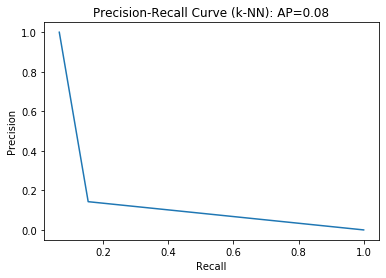

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

plt.plot(precision, recall)
plt.title('Precision-Recall Curve (k-NN): '
                   'AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')